In [1]:
import pandas as pd
import numpy as np
import glob
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [2]:
# Directory where the original data is stored
ORIGINAL_DATA_DIR = '../../../EXOSAFE-DATA'

# Number of force cells in the robotic leg
N_CELLS = 8

In [3]:
data_ls = glob.glob(ORIGINAL_DATA_DIR + '/*/*.xlsx')

print('Files found ({}):'.format(len(data_ls)))
print([file.split('/')[-1] for file in data_ls])

Files found (101):
['01-06022021.xlsx', '02-06022021.xlsx', '03-06022021.xlsx', '07-06022021.xlsx', '08-06022021.xlsx', '10-06022021.xlsx', '03-08022021.xlsx', '04-08022021.xlsx', '02-10022021.xlsx', '03-10022021.xlsx', '04-10022021.xlsx', '05-10022021.xlsx', '01-10032021.xlsx', '01-12022021.xlsx', '02-12022021.xlsx', '03-12022021.xlsx', '04-12022021.xlsx', '05-12022021.xlsx', '06-12022021.xlsx', '07-12022021.xlsx', '02-15022021.xlsx', '03-15022021.xlsx', '04-15022021.xlsx', '01-16022021.xlsx', '02-16022021.xlsx', '03-16022021.xlsx', '04-16022021.xlsx', '05-16022021.xlsx', '06-16022021.xlsx', '02-17022021.xlsx', '03-17022021.xlsx', '04-17022021.xlsx', '01-19022021.xlsx', '010-19022021.xlsx', '011-19022021.xlsx', '012-19022021.xlsx', '013-19022021.xlsx', '014-19022021.xlsx', '015-19022021.xlsx', '016-19022021.xlsx', '017-19022021.xlsx', '018-19022021.xlsx', '02-19022021.xlsx', '03-19022021.xlsx', '04-19022021.xlsx', '05-19022021.xlsx', '06-19022021.xlsx', '07-19022021.xlsx', '08-1902202

In [4]:
# Dictionary to exclude specific experiments (date: [experiment ids])
# These experiments are excluded by lack of data
EXPERIMENTS_TO_EXCLUDE = {
    '06022021': ['01', '02', '03', '07', '08', '10'],
    '08022021': ['03', '04'],
    '10022021': ['02', '03', '04', '05'],
    '12022021': ['01', '02', '03', '04', '05', '06', '07'],
    '15022021': ['02', '03', '04'],
    '26032021': ['01', '02', '03', '04', '06', '07', '09', '011', '012'],
    '21042021': ['02', '03', '04', '05', '06', '07', '08']
}

# Exclude some experiments from the list of files to process
for exp_date, exp_ids in EXPERIMENTS_TO_EXCLUDE.items():
    for i in exp_ids:
        data_ls.remove(ORIGINAL_DATA_DIR + '/{}/{}-{}.xlsx'.format(exp_date, i, exp_date))
        
print('Files to process ({}):'.format(len(data_ls)))
print([file.split('/')[-1] for file in data_ls])

Files to process (63):
['01-10032021.xlsx', '01-16022021.xlsx', '02-16022021.xlsx', '03-16022021.xlsx', '04-16022021.xlsx', '05-16022021.xlsx', '06-16022021.xlsx', '02-17022021.xlsx', '03-17022021.xlsx', '04-17022021.xlsx', '01-19022021.xlsx', '010-19022021.xlsx', '011-19022021.xlsx', '012-19022021.xlsx', '013-19022021.xlsx', '014-19022021.xlsx', '015-19022021.xlsx', '016-19022021.xlsx', '017-19022021.xlsx', '018-19022021.xlsx', '02-19022021.xlsx', '03-19022021.xlsx', '04-19022021.xlsx', '05-19022021.xlsx', '06-19022021.xlsx', '07-19022021.xlsx', '08-19022021.xlsx', '09-19022021.xlsx', '01-22022021.xlsx', '010-22022021.xlsx', '011-22022021.xlsx', '012-22022021.xlsx', '013-22022021.xlsx', '014-22022021.xlsx', '015-22022021.xlsx', '016-22022021.xlsx', '017-22022021.xlsx', '018-22022021.xlsx', '019-22022021.xlsx', '02-22022021.xlsx', '03-22022021.xlsx', '04-22022021.xlsx', '05-22022021.xlsx', '06-22022021.xlsx', '07-22022021.xlsx', '08-22022021.xlsx', '09-22022021.xlsx', '01-24022021.xlsx

## Based on time-shift parameter

In [5]:
def process_parameters_sheet(params_df):
    '''
    Process the data in the given pd.DataFrame from the raw excel sheet. 
    
    Args:
    - params_df (pd.DataFrame): DataFrame of the parameters excel sheet.
    
    Returns:
    - params_dict (dict): Dictionary with all the parameter in the input DataFrame.
    '''
    params_dict = {}
    params_dict['ExoHipMissalign'] = params_df.iloc[2, 1]
    params_dict['ExoKneeMissalign'] = params_df.iloc[2, 2]
    params_dict['MarchVelocity'] = params_df.iloc[0, 11]
    params_dict['TimeShift'] = params_df.iloc[0, 12]
    params_dict['SkinConfig'] = params_df.iloc[0, 13]
    
    return params_dict

In [6]:
# Load the data
print(data_ls[-1])
data_df = pd.read_excel(data_ls[-1], sheet_name=['Parameters', 'H3processed', 'Leg-Replica'])

../../../EXOSAFE-DATA/24022021/09-24022021.xlsx


In [7]:
exp_params = process_parameters_sheet(data_df['Parameters'])

In [8]:
def shift_leg_data(df, time_shift, total_len, data_res=0.01):
    '''
    Shift the data from the leg replica using the known time_shift from the experiment
    parameters to match the exoskeleton data in time and lenght.
    
    Args:
    - df (pd.DataFrame): DataFrame with the data of the leg replica
    - time_shift (float): Shifting time to applied to the data.
    - total_len (int): Total desired lenght for the data.
    - data_res (float): Data resolution (in seconds).
    
    Returns:
    - (pd.DataFrame): DataFrame with the data of the leg replica shifted.
    '''
    idx_start = math.ceil(time_shift / data_res)
    idx_end = total_len + idx_start
    return df.iloc[idx_start:idx_end].reset_index(drop=True)

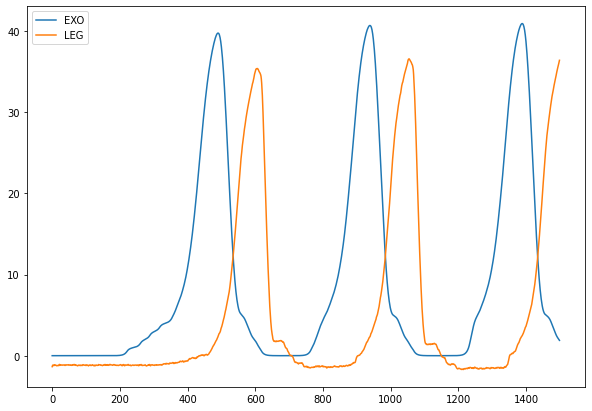

In [9]:
plt.figure(figsize=(10,7))
plt.plot(data_df['H3processed']['LKneePos'].iloc[:1500], label='EXO')
plt.plot(data_df['Leg-Replica']['LegKneePositionFiltered'].iloc[:1500], label='LEG')
plt.legend()
plt.show()

In [10]:
df = data_df['Leg-Replica'].iloc[3:]
time_shift = exp_params['TimeShift']
total_len = len(data_df['H3processed'])
data_res = 0.01

idx_start = math.ceil(time_shift / data_res)
idx_end = total_len + idx_start
leg_df_processed = df.iloc[idx_start:idx_end].reset_index(drop=True)

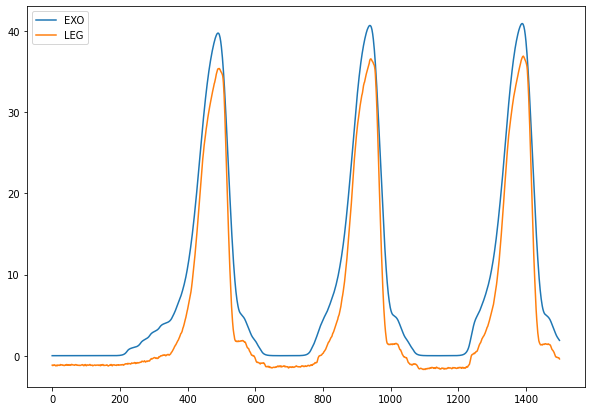

In [11]:
plt.figure(figsize=(10,7))
plt.plot(data_df['H3processed']['LKneePos'].iloc[:1500], label='EXO')
plt.plot(leg_df_processed['LegKneePositionFiltered'].iloc[:1500], label='LEG')
plt.legend()
plt.show()

## Based on the difference between maxima

In [4]:
# Load the data
data_df = pd.read_excel('../../../EXOSAFE-DATA/24022021/07-24022021.xlsx', sheet_name=['Parameters', 'H3processed', 'Leg-Replica'])

In [5]:
# Ideal time shift obtained from the experimental setup
exp_time_shift = data_df['Parameters'].iloc[0]['TimeShift']
print('Experimental time shift: {}'.format(exp_time_shift))

Experimental time shift: 0.6999999999999997


In [6]:
exo_arr = data_df['H3processed'].iloc[:, 1].values
leg_arr = data_df['Leg-Replica'].iloc[:, 3].values

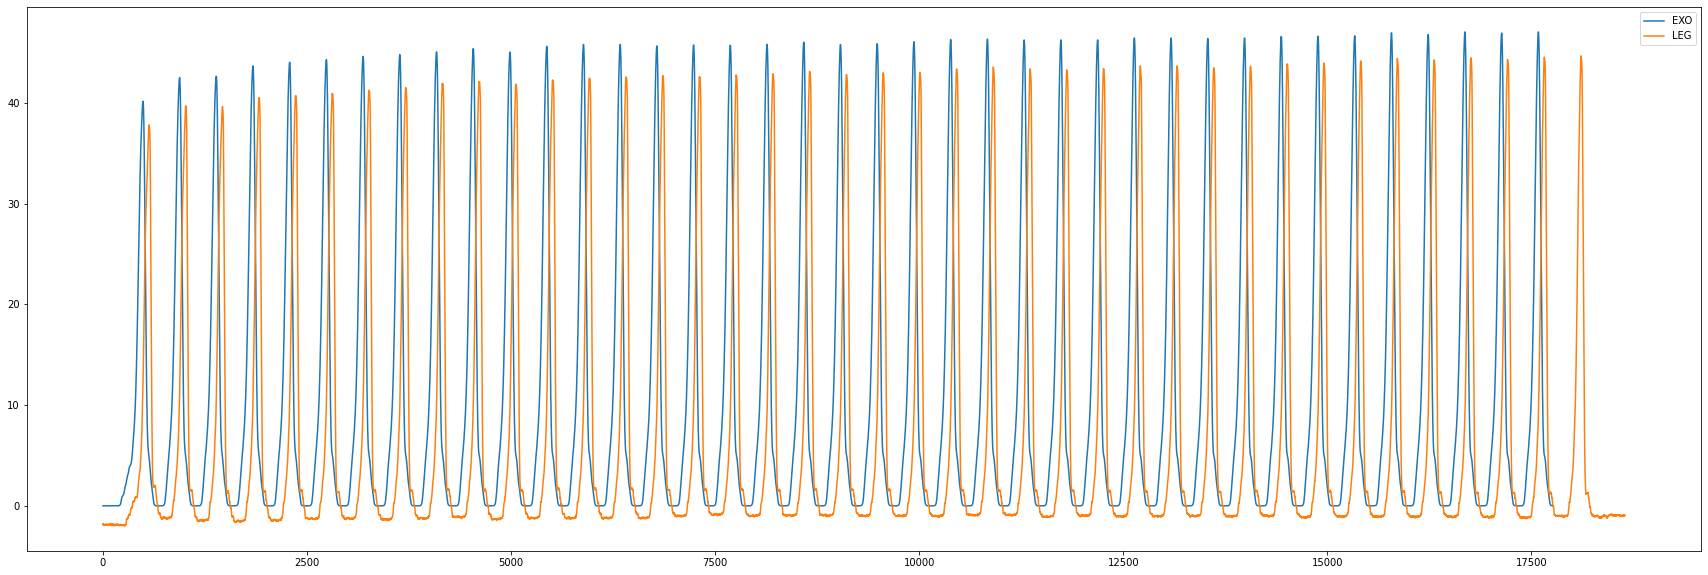

In [7]:
# Plot exo and leg position signals
plt.figure(figsize=(30,10))
plt.plot(exo_arr, label='EXO')
plt.plot(leg_arr, label='LEG')
plt.legend()
plt.show()

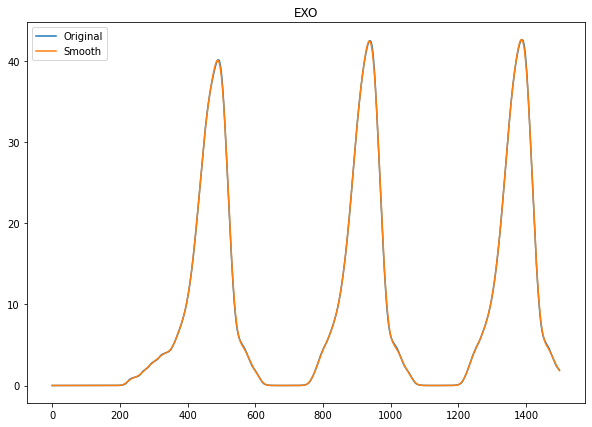

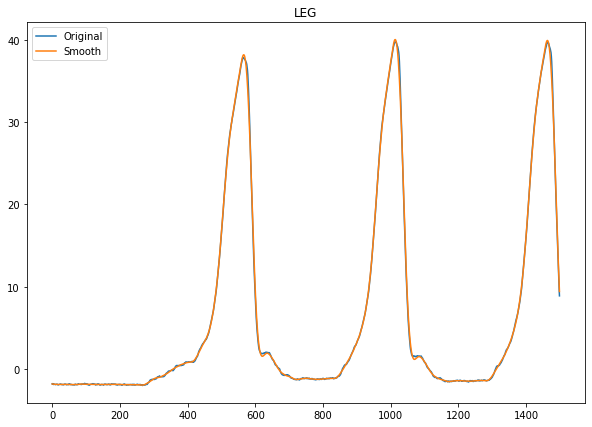

In [8]:
# Smooth the exo and leg position signal

exo_arr_smooth = savgol_filter(exo_arr, 51, 3) # window size 51, polynomial order 3

plt.figure(figsize=(10,7))
plt.plot(exo_arr[:1500], label='Original')
plt.plot(exo_arr_smooth[:1500], label='Smooth')
plt.title('EXO')
plt.legend()
plt.show()


leg_arr_smooth = savgol_filter(leg_arr, 51, 3) # window size 51, polynomial order 3

plt.figure(figsize=(10,7))
plt.plot(leg_arr[:1500], label='Original')
plt.plot(leg_arr_smooth[:1500], label='Smooth')
plt.title('LEG')
plt.legend()
plt.show()

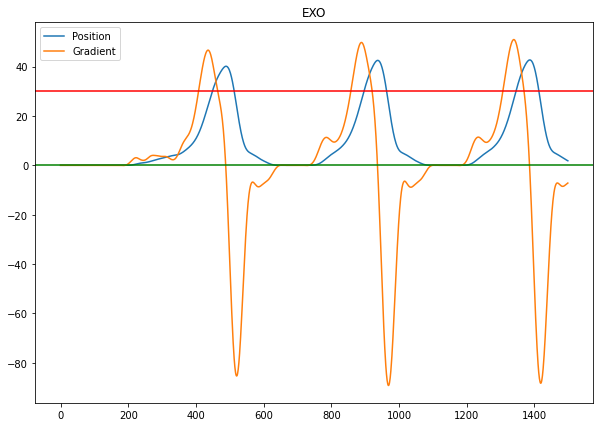

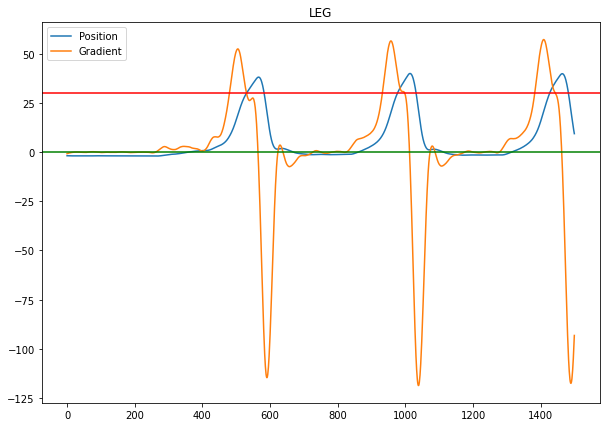

In [9]:
f_spacing = 0.01
threshold = 30
# Compute derivative of the signal to find de local maxima
exo_dev = np.gradient(exo_arr_smooth, f_spacing)
exo_dev_smooth = savgol_filter(exo_dev, 51, 3) # window size 51, polynomial order 3

plt.figure(figsize=(10,7))
plt.plot(exo_arr_smooth[:1500], label='Position')
plt.plot(exo_dev_smooth[:1500], label='Gradient')
plt.axhline(y=threshold, c='r')
plt.axhline(y=0, c='g')
plt.legend()
plt.title('EXO')
plt.show()


leg_dev = np.gradient(leg_arr_smooth, f_spacing)
leg_dev_smooth = savgol_filter(leg_dev, 51, 3) # window size 51, polynomial order 3

plt.figure(figsize=(10,7))
plt.plot(leg_arr_smooth[:1500], label='Position')
plt.plot(leg_dev_smooth[:1500], label='Gradient')
plt.axhline(y=threshold, c='r')
plt.axhline(y=0, c='g')
plt.legend()
plt.title('LEG')
plt.show()

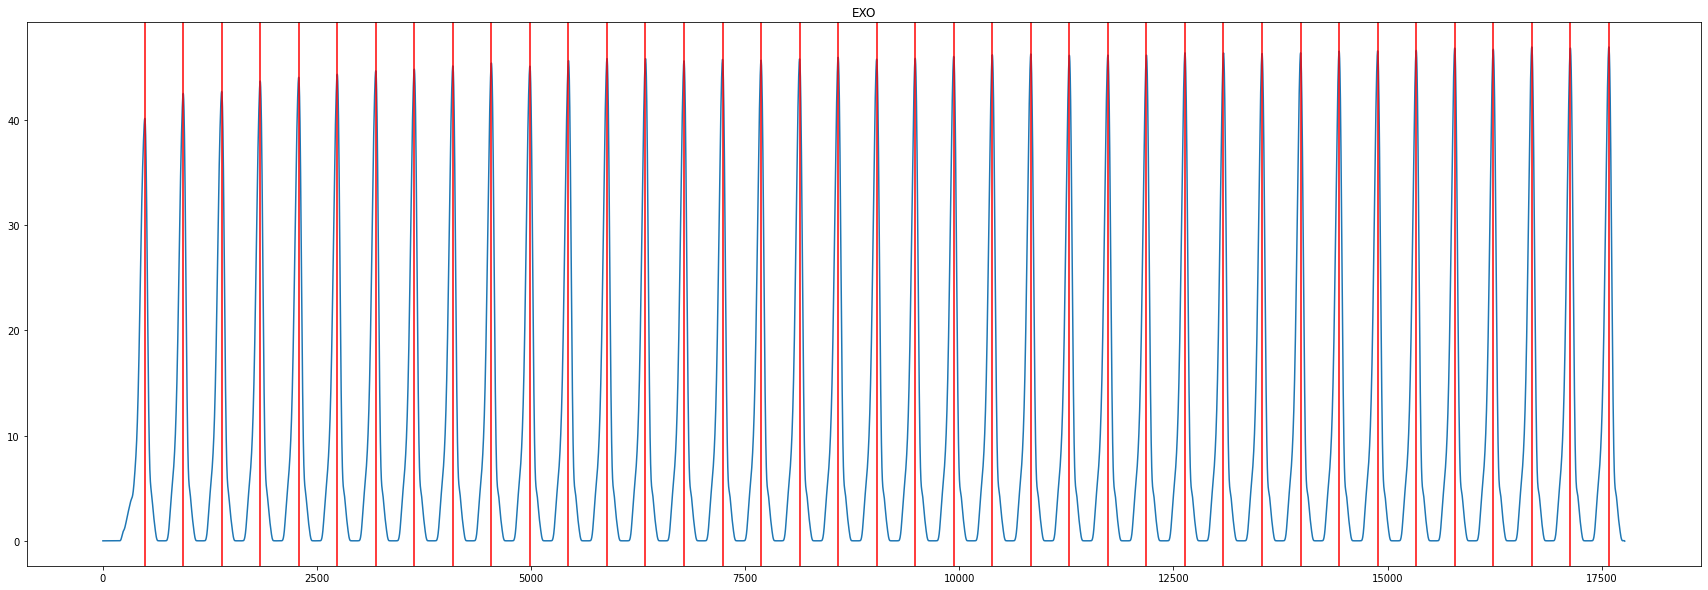

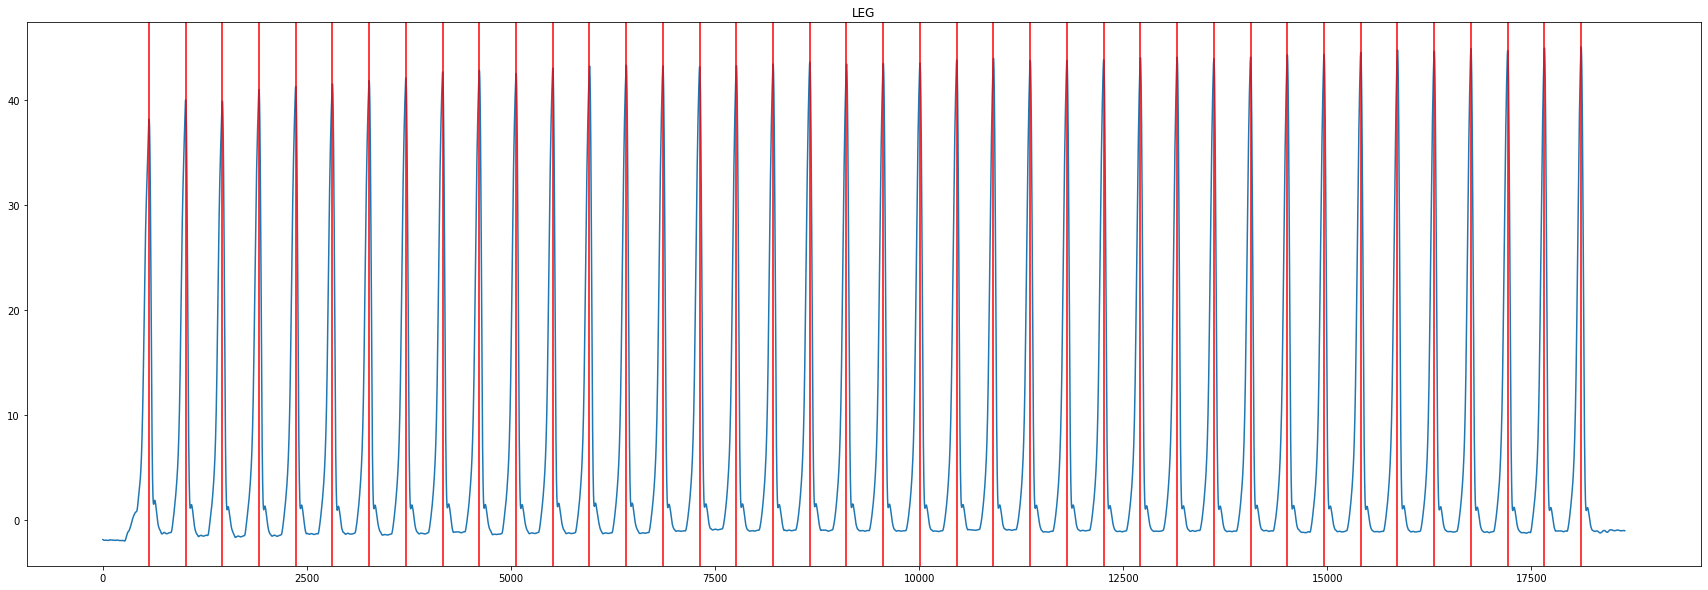

In [10]:
# Find the x coordinate of the maximum points

plt.figure(figsize=(30,10))
plt.plot(exo_arr_smooth)

# Add some padding to detect easily the threshold cross
exo_idx_max = []
searching = False
for i in range(1, exo_dev_smooth.shape[0]):
    if exo_dev_smooth[i - 1] > threshold and exo_dev_smooth[i] < threshold:
        searching = True
    if searching and exo_dev_smooth[i - 1] > 0 and exo_dev_smooth[i] < 0:
        searching = False
        exo_idx_max.append(i)
        plt.axvline(x=i, c='r')
        
plt.title('EXO')
plt.show()


plt.figure(figsize=(30,10))
plt.plot(leg_arr_smooth)

leg_idx_max = []
searching = False
for i in range(1, leg_dev_smooth.shape[0]):
    if leg_dev_smooth[i - 1] > threshold and leg_dev_smooth[i] < threshold:
        searching = True
    if searching and leg_dev_smooth[i - 1] > 0 and leg_dev_smooth[i] < 0:
        searching = False
        leg_idx_max.append(i)
        plt.axvline(x=i, c='r')
        
plt.title('LEG')
plt.show()

In [11]:
# Compute the location of the max points in time scale
exo_maxs = np.array(np.arange(0, len(exo_arr) * 0.01, 0.01)[exo_idx_max])
leg_maxs = np.array(np.arange(0, len(leg_arr) * 0.01, 0.01)[leg_idx_max])


In [12]:
min_aux = np.min([len(exo_maxs), len(leg_maxs)])

exo_maxs = exo_maxs[:min_aux]
leg_maxs = leg_maxs[:min_aux]

In [13]:
print(len(exo_maxs))
print(len(leg_maxs))

39
39


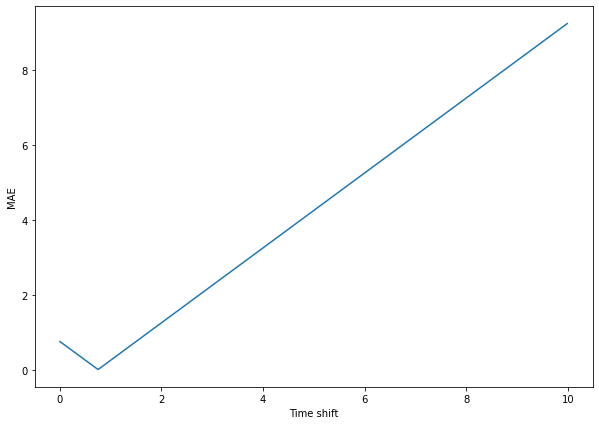

Ideal time shift: 0.7500


In [14]:
time_shift_ls = np.arange(0, 10, 0.01)

MAE_ls = []
for ts in time_shift_ls:
    MAE_ls.append(mean_absolute_error(exo_maxs, leg_maxs - ts))
    
plt.figure(figsize=(10,7))
plt.plot(time_shift_ls, MAE_ls)
plt.xlabel('Time shift')
plt.ylabel('MAE')
plt.show()

time_shift = time_shift_ls[np.argmin(MAE_ls)]
print('Ideal time shift: {:.4f}'.format(time_shift))

In [15]:
print('Absolute error: {}'.format(abs(exp_time_shift - time_shift)))

Absolute error: 0.050000000000000266


In [16]:
def shift_leg_data(df, time_shift, total_len, data_res=0.01):
    '''
    Shift the data from the leg replica using the known time_shift from the experiment
    parameters to match the exoskeleton data in time and lenght.
    
    Args:
    - df (pd.DataFrame): DataFrame with the data of the leg replica
    - time_shift (float): Shifting time to applied to the data.
    - total_len (int): Total desired lenght for the data.
    - data_res (float): Data resolution (in seconds).
    
    Returns:
    - (pd.DataFrame): DataFrame with the data of the leg replica shifted.
    '''
    idx_start = math.ceil(time_shift / data_res)
    idx_end = total_len + idx_start
    return df.iloc[idx_start:idx_end].reset_index(drop=True)

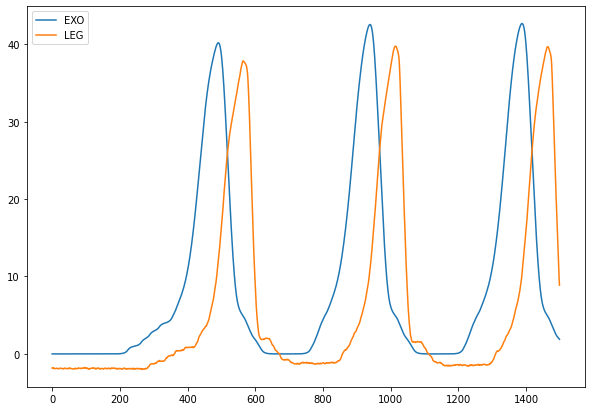

In [17]:
plt.figure(figsize=(10,7))
plt.plot(data_df['H3processed']['LKneePos'].iloc[:1500], label='EXO')
plt.plot(data_df['Leg-Replica']['LegKneePositionFiltered'].iloc[:1500], label='LEG')
plt.legend()
plt.show()

In [18]:
leg_df_processed = shift_leg_data(data_df['Leg-Replica'], time_shift, len(data_df['H3processed']))

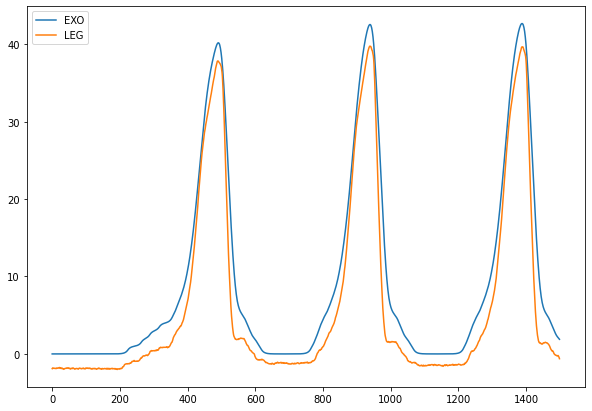

In [19]:
plt.figure(figsize=(10,7))
plt.plot(data_df['H3processed']['LKneePos'].iloc[:1500], label='EXO')
plt.plot(leg_df_processed['LegKneePositionFiltered'].iloc[:1500], label='LEG')
plt.legend()
plt.show()

In [7]:
def shift_leg_data(df, time_shift, total_len, data_res=0.01):
    '''
    Shift the data from the leg replica using the known time_shift from the experiment
    parameters to match the exoskeleton data in time and lenght.
    
    Args:
    - df (pd.DataFrame): DataFrame with the data of the leg replica
    - time_shift (float): Shifting time to applied to the data.
    - total_len (int): Total desired lenght for the data.
    - data_res (float): Data resolution (in seconds).
    
    Returns:
    - (pd.DataFrame): DataFrame with the data of the leg replica shifted.
    '''
    idx_start = math.ceil(time_shift / data_res)
    idx_end = total_len + idx_start
    return df.iloc[idx_start:idx_end].reset_index(drop=True)

def compute_time_shift(exo_knee_pos, leg_knee_pos, data_res=0.01, window_size=51, pol_order=3, threshold=30, max_time_shift=10):
    '''
    
    Args:
    - exo_knee_pos (np.array):
    - leg_knee_pos (np.array):
    - data_res (float) [default = 0.01]:
    - window_size (int) [default = 51]:
    - pol_order (int) [default = 3]:
    - threshold (int) [default = 30]:
    - max_time_shift (int) [default = 10]:
    
    Return:
    - time_shift (float):
    '''
    # Smooth the exo and leg position signal
    exo_arr_smooth = savgol_filter(exo_knee_pos, window_size, pol_order) # window size 51, polynomial order 3
    leg_arr_smooth = savgol_filter(leg_knee_pos, window_size, pol_order) 
    
    # Compute derivative of the signal to find de local maxima
    exo_dev = np.gradient(exo_arr_smooth, data_res)
    exo_dev_smooth = savgol_filter(exo_dev, window_size, pol_order) 
    leg_dev = np.gradient(leg_arr_smooth, data_res)
    leg_dev_smooth = savgol_filter(leg_dev, window_size, pol_order)
    
    # Find the x coordinate of the maximum points
    exo_idx_max = []
    searching = False
    for i in range(1, exo_dev_smooth.shape[0]):
        # Search for a point where the gradient is decreasing before cross 0
        if exo_dev_smooth[i - 1] > threshold and exo_dev_smooth[i] < threshold:
            searching = True
        # Only if the gradient is decreasing from a point higher than threshold,
        # then search for a 0 crossing
        if searching and exo_dev_smooth[i - 1] > 0 and exo_dev_smooth[i] < 0:
            searching = False
            exo_idx_max.append(i)

    leg_idx_max = []
    searching = False
    for i in range(1, leg_dev_smooth.shape[0]):
        # Search for a point where the gradient is decreasing before cross 0
        if leg_dev_smooth[i - 1] > threshold and leg_dev_smooth[i] < threshold:
            searching = True
        # Only if the gradient is decreasing from a point higher than threshold,
        # then search for a 0 crossing
        if searching and leg_dev_smooth[i - 1] > 0 and leg_dev_smooth[i] < 0:
            searching = False
            leg_idx_max.append(i)

    # Compute the location of the max points in time scale
    exo_maxs = np.array(np.arange(0, len(exo_arr) * data_res, data_res)[exo_idx_max])
    leg_maxs = np.array(np.arange(0, len(leg_arr) * data_res, data_res)[leg_idx_max])

    min_aux = np.min([len(exo_maxs), len(leg_maxs)])

    exo_maxs = exo_maxs[:min_aux]
    leg_maxs = leg_maxs[:min_aux]
    
    time_shift_ls = np.arange(0, max_time_shift, data_res)

    MAE_ls = []
    for ts in time_shift_ls:
        MAE_ls.append(mean_absolute_error(exo_maxs, leg_maxs - ts))

    time_shift = time_shift_ls[np.argmin(MAE_ls)]
    
    return time_shift

../../../EXOSAFE-DATA/10032021/01-10032021.xlsx
Experimental time shift: 0.7049999999999992
Ideal time shift: 0.7100


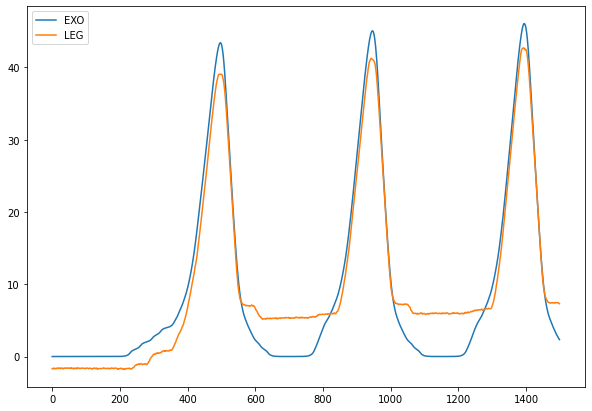



../../../EXOSAFE-DATA/16022021/01-16022021.xlsx
Experimental time shift: 0.910000000000001
Ideal time shift: 0.9300


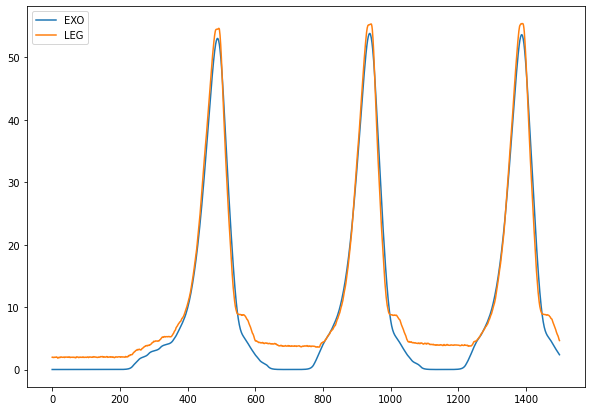



../../../EXOSAFE-DATA/16022021/02-16022021.xlsx
Experimental time shift: 1.2300000000000004
Ideal time shift: 1.2000


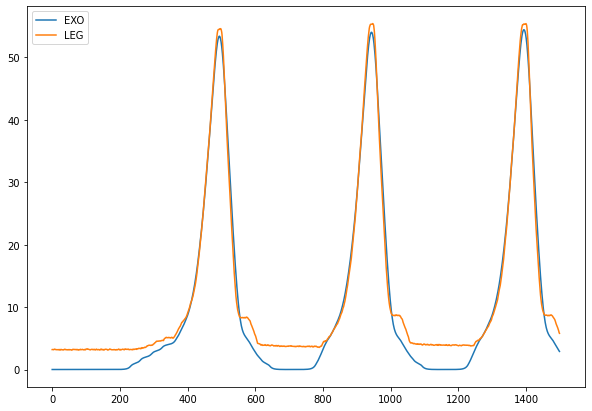



../../../EXOSAFE-DATA/16022021/03-16022021.xlsx
Experimental time shift: 0.8499999999999996
Ideal time shift: 0.8700


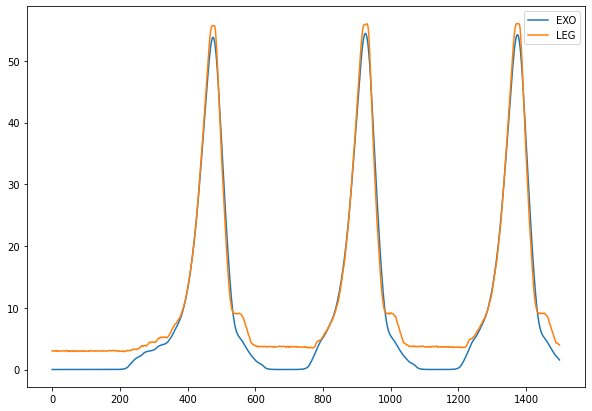



../../../EXOSAFE-DATA/16022021/04-16022021.xlsx
Experimental time shift: 0.3850000000000007
Ideal time shift: 0.4300


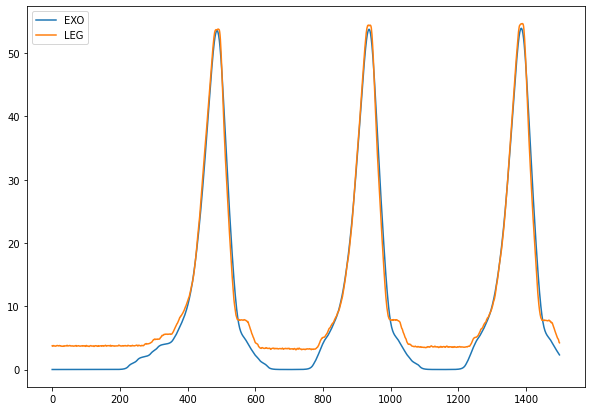



../../../EXOSAFE-DATA/16022021/05-16022021.xlsx
Experimental time shift: 1.005
Ideal time shift: 1.0200


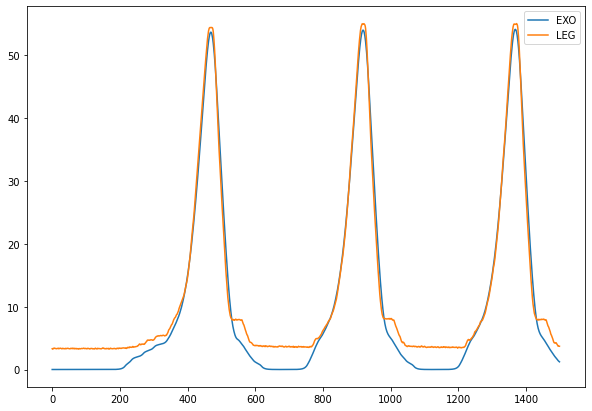



../../../EXOSAFE-DATA/16022021/06-16022021.xlsx
Experimental time shift: 1.58
Ideal time shift: 1.5800


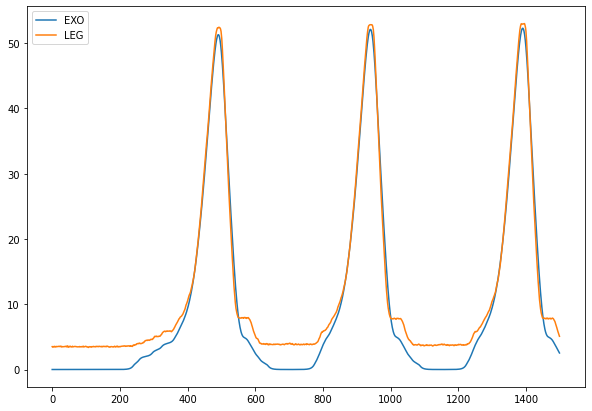



../../../EXOSAFE-DATA/17022021/02-17022021.xlsx
Experimental time shift: 0.8449999999999998
Ideal time shift: 0.8800


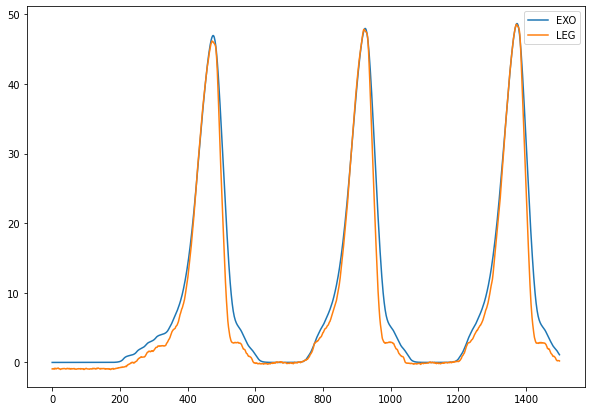



../../../EXOSAFE-DATA/17022021/03-17022021.xlsx
Experimental time shift: 0.3850000000000007
Ideal time shift: 0.3900


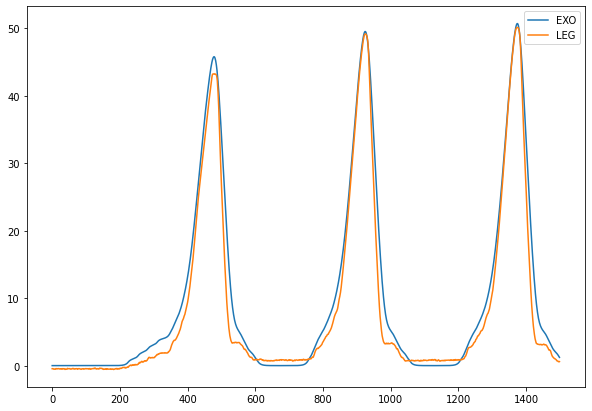



../../../EXOSAFE-DATA/17022021/04-17022021.xlsx
Experimental time shift: 1.1400000000000006
Ideal time shift: 1.1200


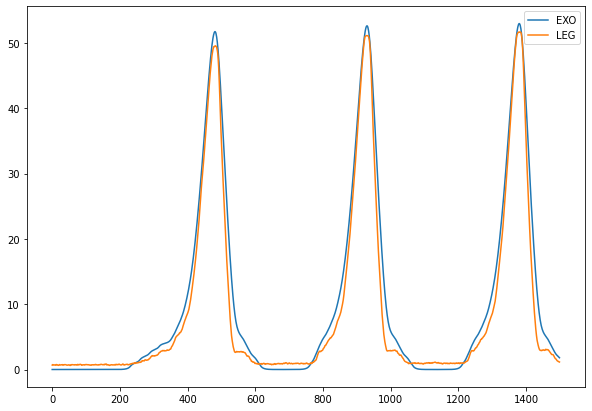



../../../EXOSAFE-DATA/19022021/01-19022021.xlsx
Experimental time shift: 0.9150000000000009
Ideal time shift: 0.9100


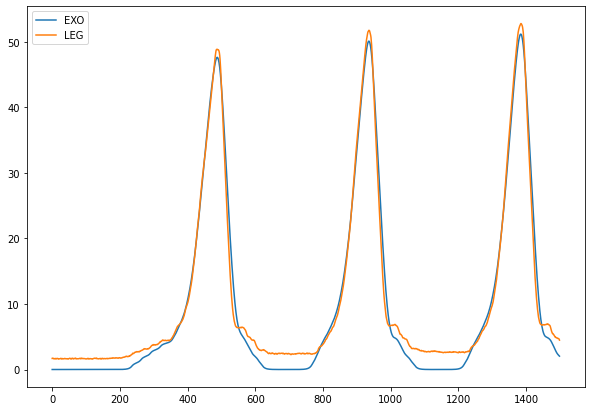



../../../EXOSAFE-DATA/19022021/010-19022021.xlsx
Experimental time shift: 0.5199999999999996
Ideal time shift: 0.5600


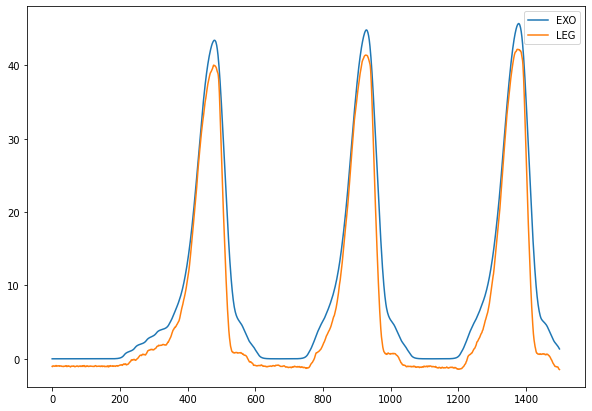



../../../EXOSAFE-DATA/19022021/011-19022021.xlsx
Experimental time shift: 0.6399999999999997
Ideal time shift: 0.6600


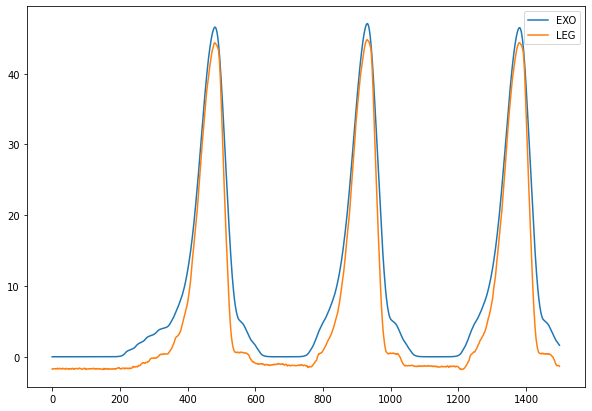



../../../EXOSAFE-DATA/19022021/012-19022021.xlsx
Experimental time shift: 0.40000000000000036
Ideal time shift: 0.3800


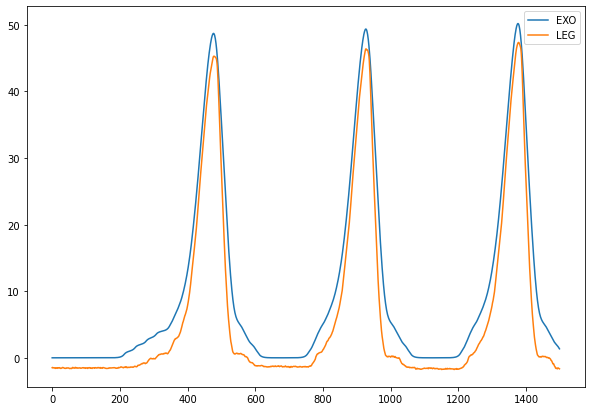



../../../EXOSAFE-DATA/19022021/013-19022021.xlsx
Experimental time shift: 0.8699999999999992
Ideal time shift: 0.8700


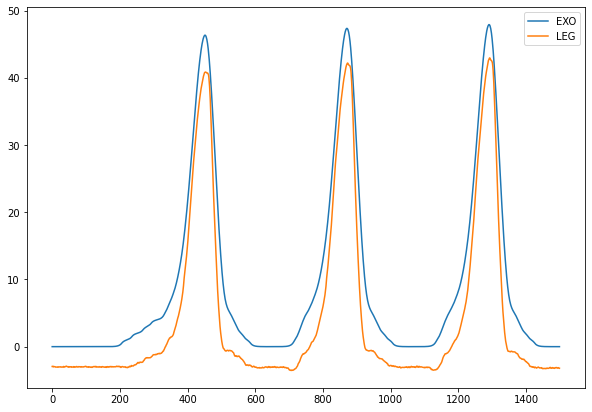



../../../EXOSAFE-DATA/19022021/014-19022021.xlsx
Experimental time shift: 0.6800000000000006
Ideal time shift: 0.7100


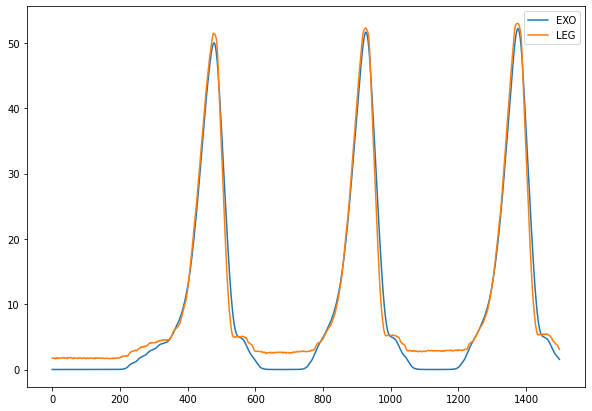



../../../EXOSAFE-DATA/19022021/015-19022021.xlsx
Experimental time shift: 0.2699999999999996
Ideal time shift: 0.2700


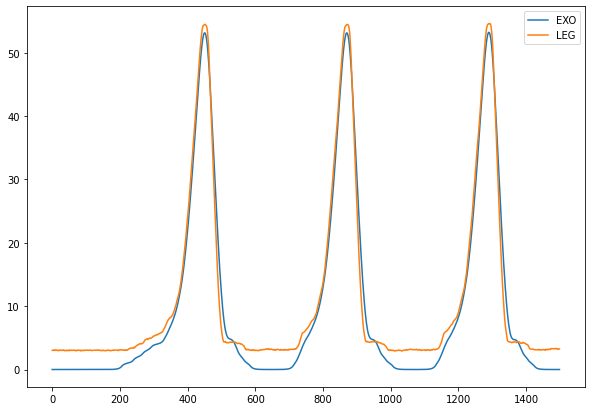



../../../EXOSAFE-DATA/19022021/016-19022021.xlsx
Experimental time shift: 0.4450000000000003
Ideal time shift: 0.4700


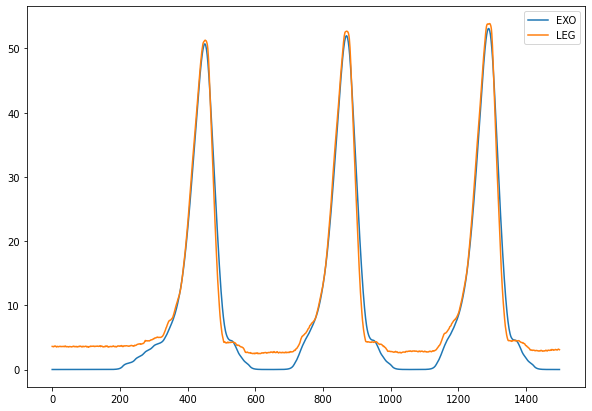



../../../EXOSAFE-DATA/19022021/017-19022021.xlsx
Experimental time shift: 0.3250000000000002
Ideal time shift: 0.3700


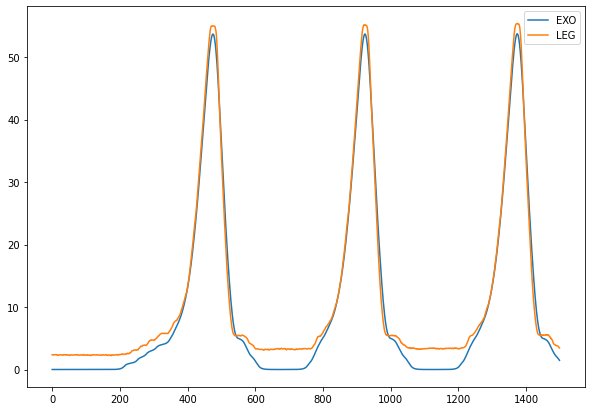



../../../EXOSAFE-DATA/19022021/018-19022021.xlsx
Experimental time shift: 0.5400000000000009
Ideal time shift: 0.5900


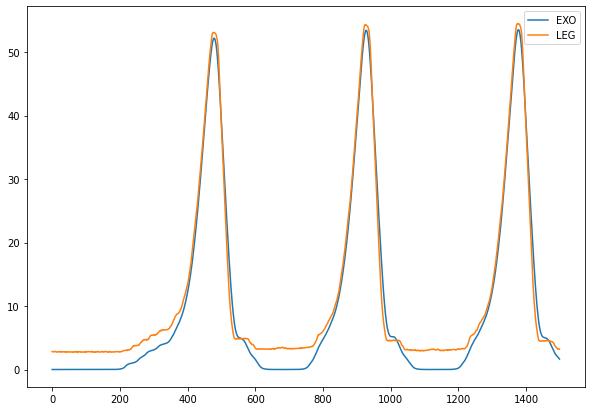



../../../EXOSAFE-DATA/19022021/02-19022021.xlsx
Experimental time shift: 0.8699999999999992
Ideal time shift: 0.8600


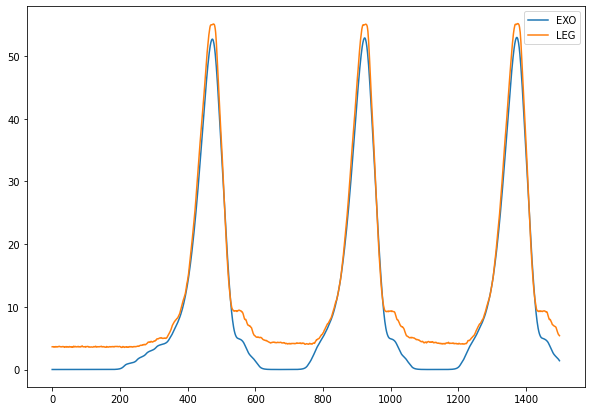



../../../EXOSAFE-DATA/19022021/03-19022021.xlsx
Experimental time shift: 0.45500000000000007
Ideal time shift: 0.4300


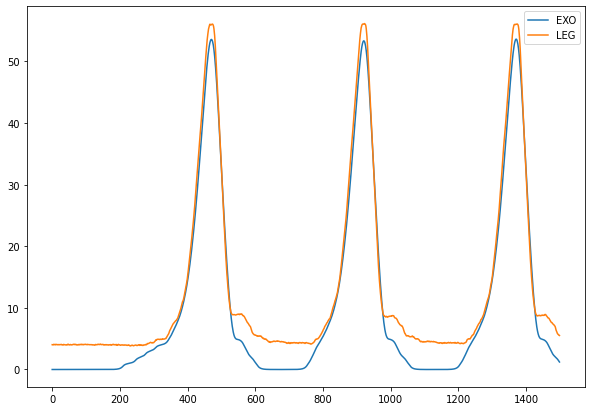



../../../EXOSAFE-DATA/19022021/04-19022021.xlsx
Experimental time shift: 0.7999999999999998
Ideal time shift: 0.7800


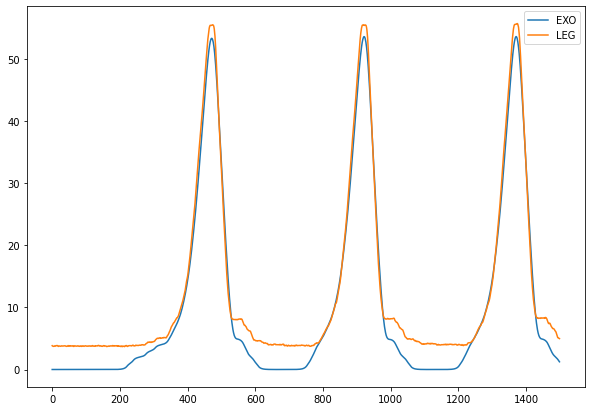



../../../EXOSAFE-DATA/19022021/05-19022021.xlsx
Experimental time shift: 0.5249999999999995
Ideal time shift: 0.5200


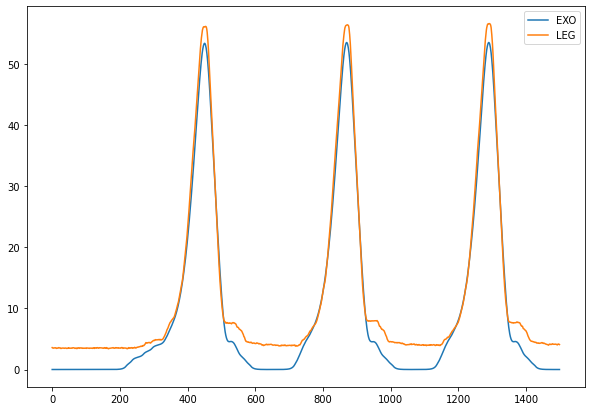



../../../EXOSAFE-DATA/19022021/06-19022021.xlsx
Experimental time shift: 0.29499999999999993
Ideal time shift: 0.3400


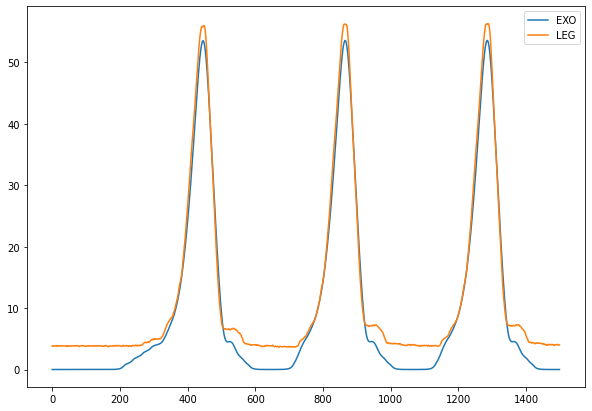



../../../EXOSAFE-DATA/19022021/07-19022021.xlsx
Experimental time shift: 0.6000000000000005
Ideal time shift: 0.6200


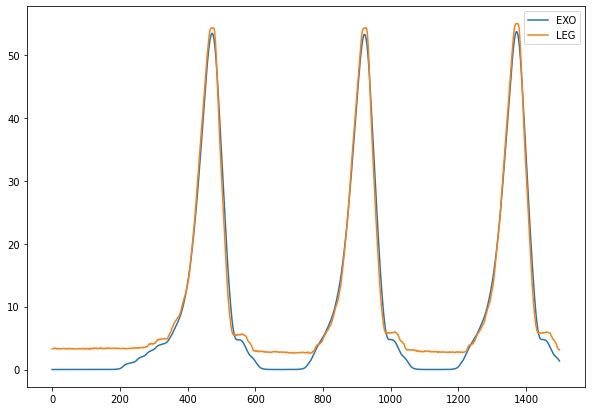



../../../EXOSAFE-DATA/19022021/08-19022021.xlsx
Experimental time shift: 0.16500000000000004
Ideal time shift: 0.1300


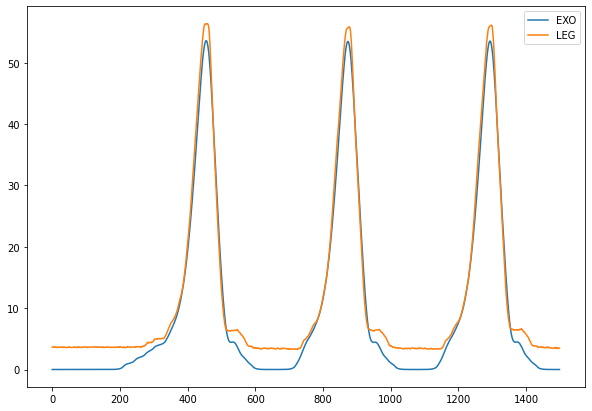



../../../EXOSAFE-DATA/19022021/09-19022021.xlsx
Experimental time shift: 0.9199999999999999
Ideal time shift: 0.9700


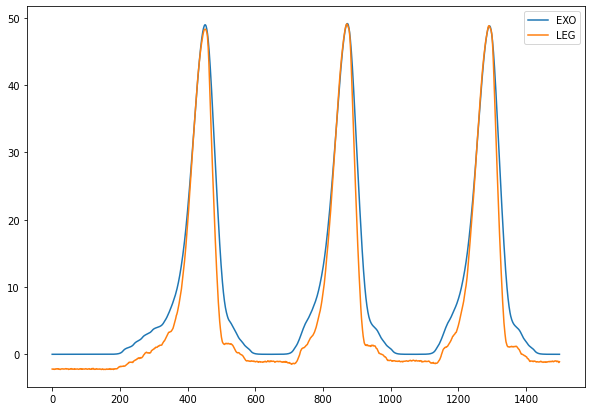



../../../EXOSAFE-DATA/22022021/01-22022021.xlsx
Experimental time shift: 0.6699999999999999
Ideal time shift: 0.6900


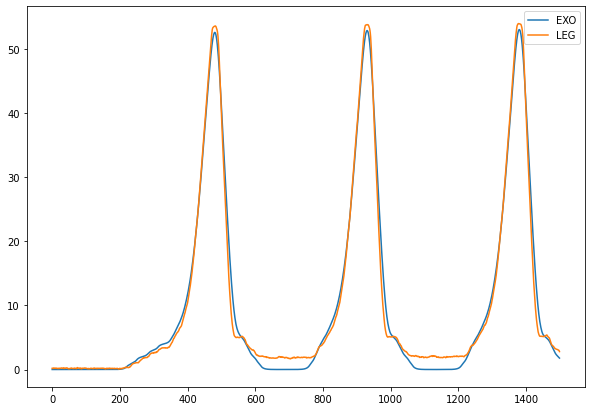



../../../EXOSAFE-DATA/22022021/010-22022021.xlsx
Experimental time shift: 0.2600000000000007
Ideal time shift: 0.3200


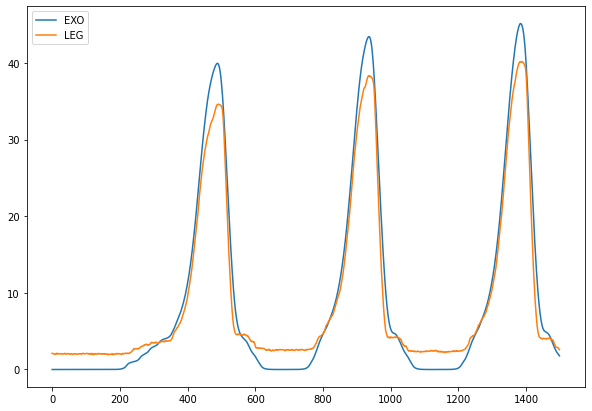



../../../EXOSAFE-DATA/22022021/011-22022021.xlsx
Experimental time shift: 0.9450000000000003
Ideal time shift: 0.9900


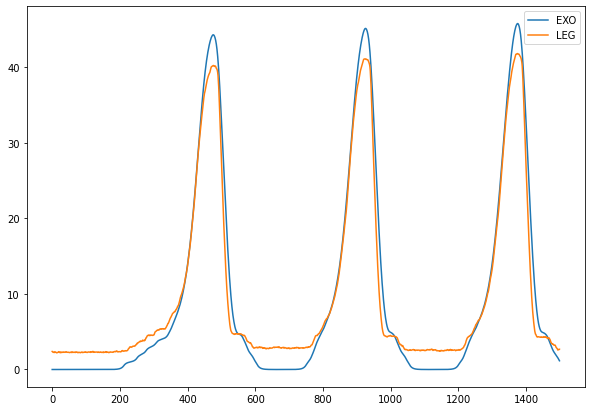



../../../EXOSAFE-DATA/22022021/012-22022021.xlsx
Experimental time shift: 0.8799999999999999
Ideal time shift: 0.8900


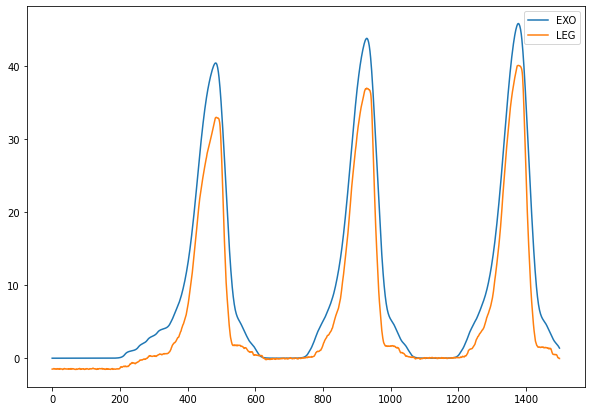



../../../EXOSAFE-DATA/22022021/013-22022021.xlsx
Experimental time shift: 0.040000000000000036
Ideal time shift: 0.0500


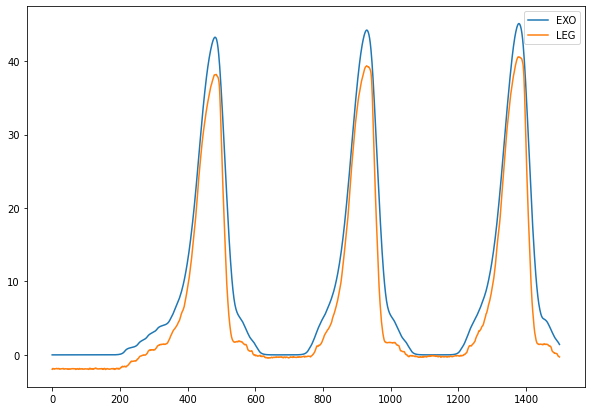



../../../EXOSAFE-DATA/22022021/014-22022021.xlsx
Experimental time shift: 0.4900000000000002
Ideal time shift: 0.5000


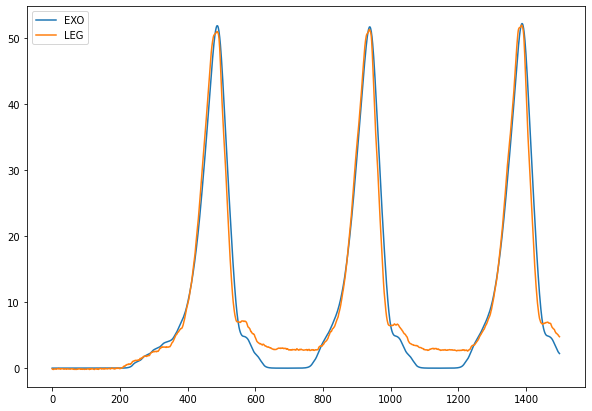



../../../EXOSAFE-DATA/22022021/015-22022021.xlsx
Experimental time shift: 1.0600000000000005
Ideal time shift: 1.0400


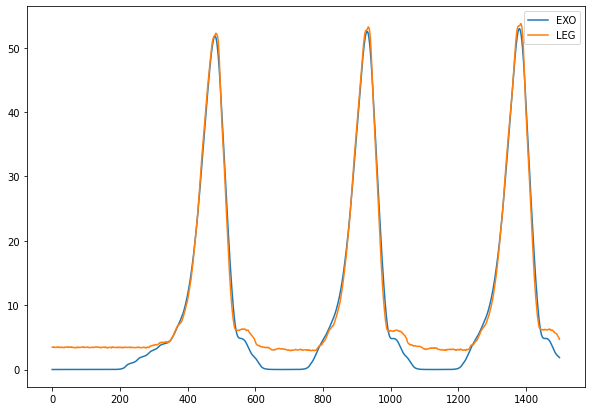



../../../EXOSAFE-DATA/22022021/016-22022021.xlsx
Experimental time shift: 0.20500000000000007
Ideal time shift: 0.3300


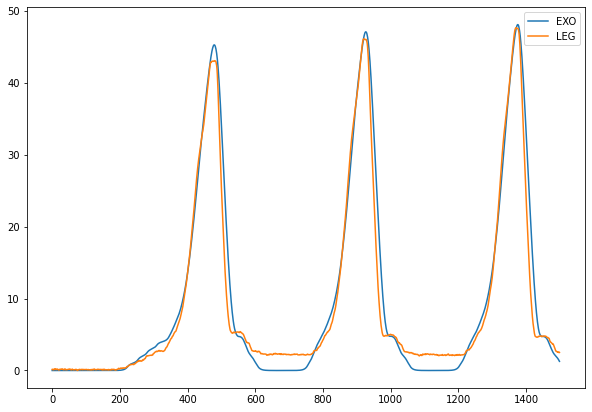



../../../EXOSAFE-DATA/22022021/017-22022021.xlsx
Experimental time shift: 0.9199999999999999
Ideal time shift: 0.9200


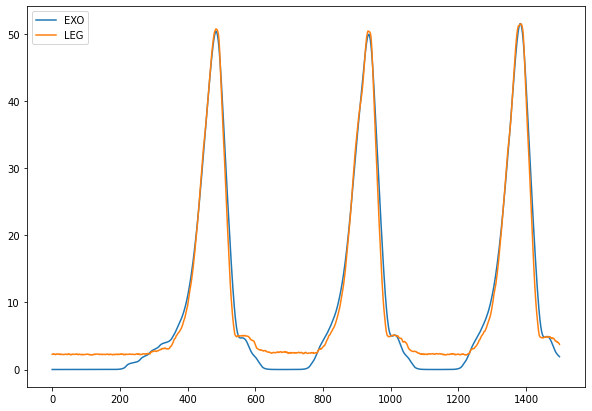



../../../EXOSAFE-DATA/22022021/018-22022021.xlsx
Experimental time shift: 0.9899999999999993
Ideal time shift: 0.9700


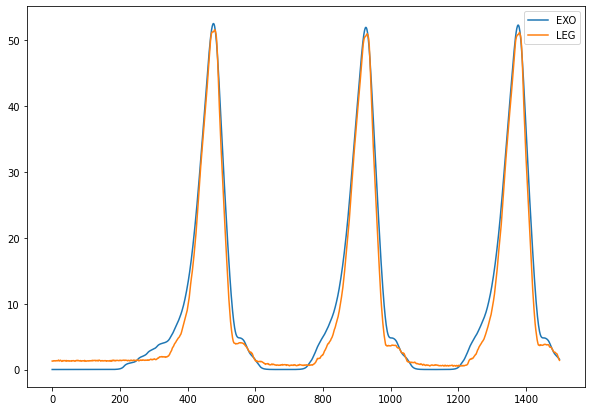



../../../EXOSAFE-DATA/22022021/019-22022021.xlsx
Experimental time shift: 0.3849999999999998
Ideal time shift: 0.3500


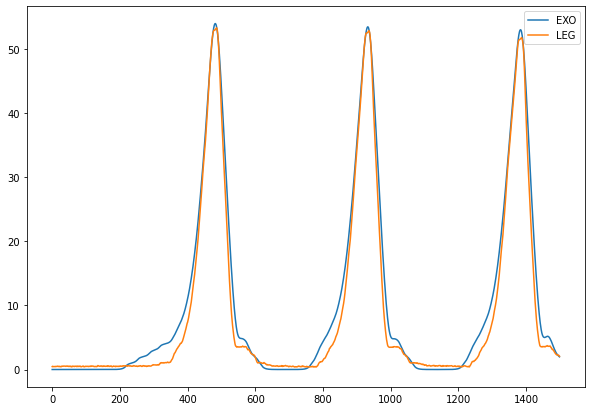



../../../EXOSAFE-DATA/22022021/02-22022021.xlsx
Experimental time shift: 0.2699999999999996
Ideal time shift: 0.3200


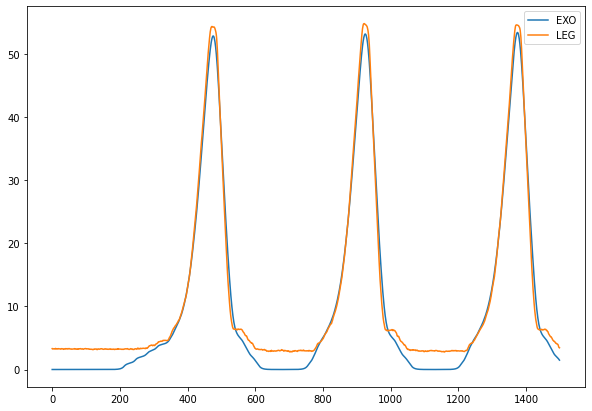



../../../EXOSAFE-DATA/22022021/03-22022021.xlsx
Experimental time shift: 0.5750000000000002
Ideal time shift: 0.6000


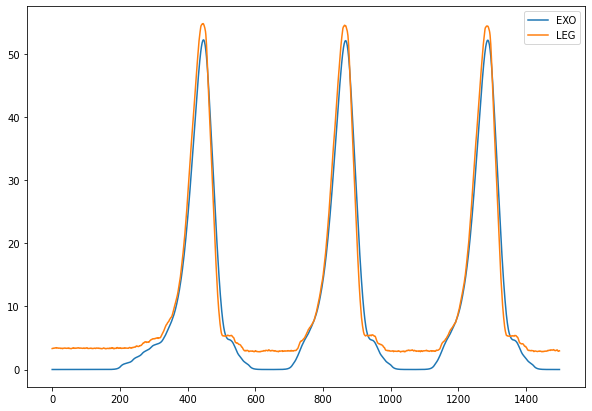



../../../EXOSAFE-DATA/22022021/04-22022021.xlsx
Experimental time shift: 0.34999999999999964
Ideal time shift: 0.3700


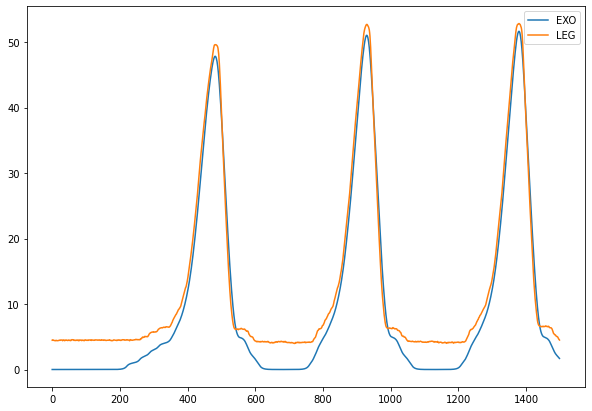



../../../EXOSAFE-DATA/22022021/05-22022021.xlsx
Experimental time shift: 0.2400000000000002
Ideal time shift: 0.2400


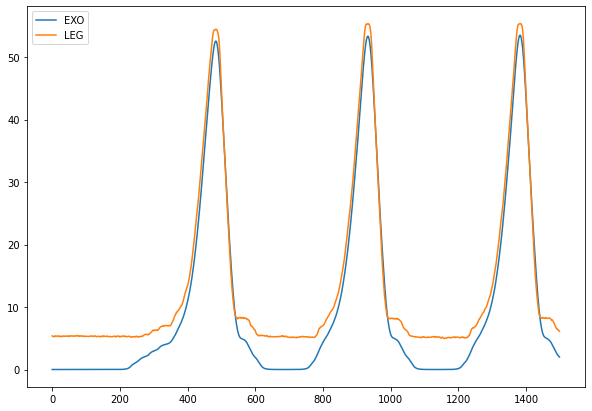



../../../EXOSAFE-DATA/22022021/06-22022021.xlsx
Experimental time shift: 0.5950000000000006
Ideal time shift: 0.6100


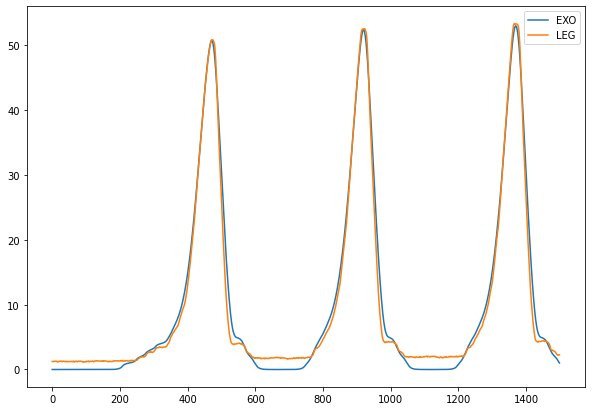



../../../EXOSAFE-DATA/22022021/07-22022021.xlsx
Experimental time shift: 0.7750000000000004
Ideal time shift: 0.8300


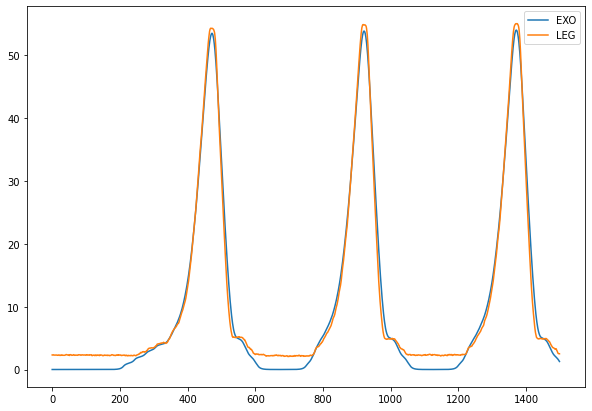



../../../EXOSAFE-DATA/22022021/08-22022021.xlsx
Experimental time shift: 0.45999999999999996
Ideal time shift: 0.6000


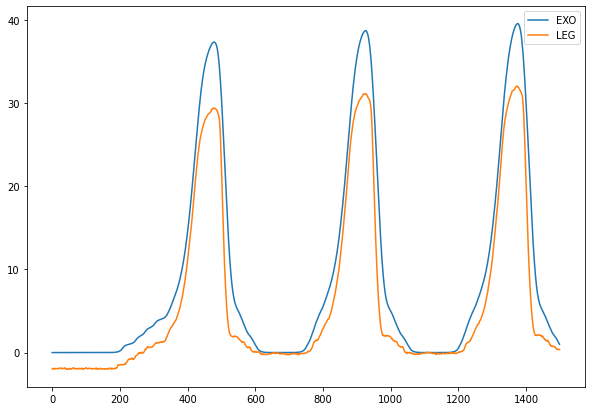



../../../EXOSAFE-DATA/22022021/09-22022021.xlsx
Experimental time shift: 0.14000000000000057
Ideal time shift: 0.2100


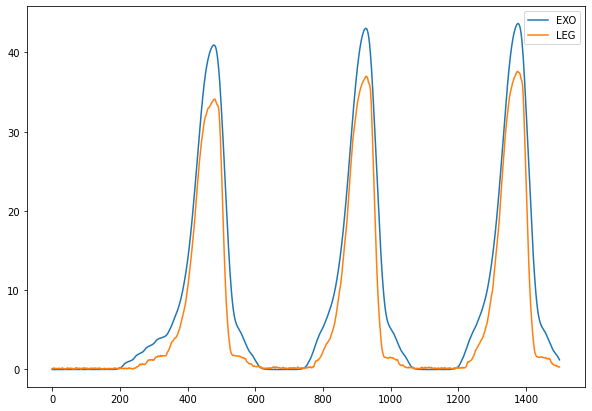



../../../EXOSAFE-DATA/24022021/01-24022021.xlsx
Experimental time shift: 0.6699999999999999
Ideal time shift: 0.6500


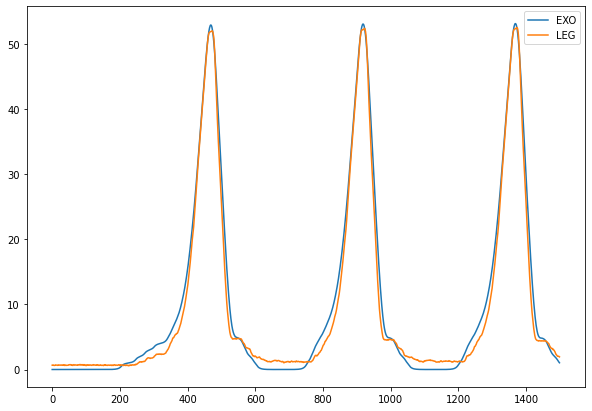



../../../EXOSAFE-DATA/24022021/010-24022021.xlsx
Experimental time shift: 2.8850000000000007
Ideal time shift: 3.8300


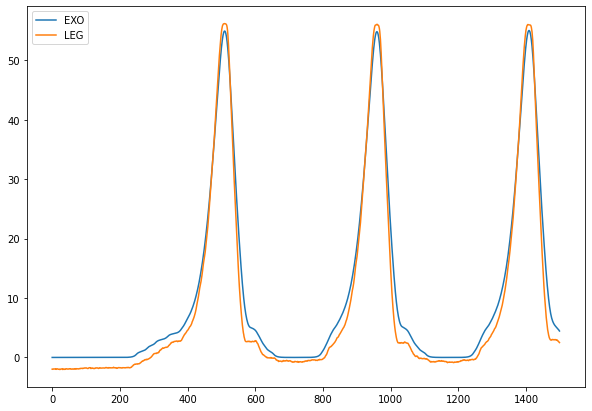



../../../EXOSAFE-DATA/24022021/011-24022021.xlsx
Experimental time shift: 0.5949999999999998
Ideal time shift: 0.6500


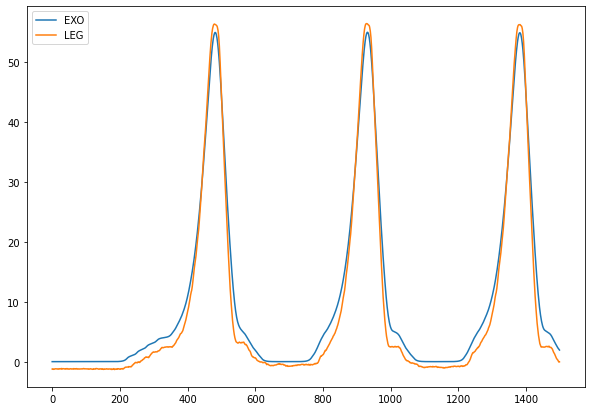



../../../EXOSAFE-DATA/24022021/012-24022021.xlsx
Experimental time shift: 0.9749999999999996
Ideal time shift: 1.0000


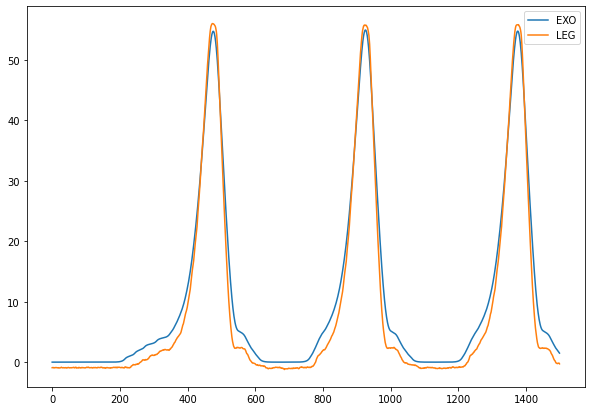



../../../EXOSAFE-DATA/24022021/013-24022021.xlsx
Experimental time shift: 0.5550000000000006
Ideal time shift: 0.6200


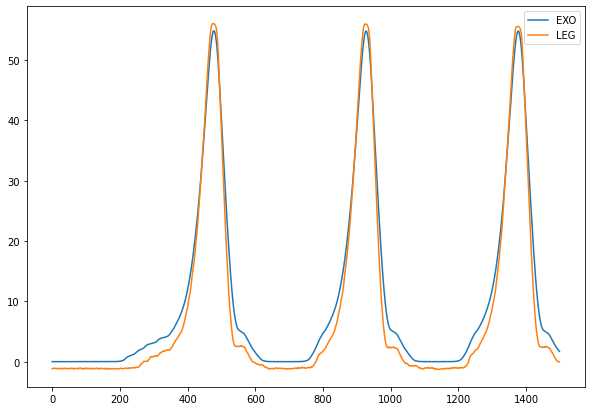



../../../EXOSAFE-DATA/24022021/014-24022021.xlsx
Experimental time shift: 0.3949999999999996
Ideal time shift: 0.4400


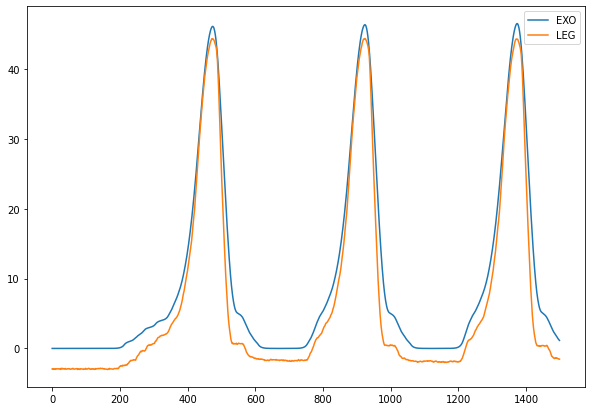



../../../EXOSAFE-DATA/24022021/015-24022021.xlsx
Experimental time shift: 0.5450000000000008
Ideal time shift: 0.6100


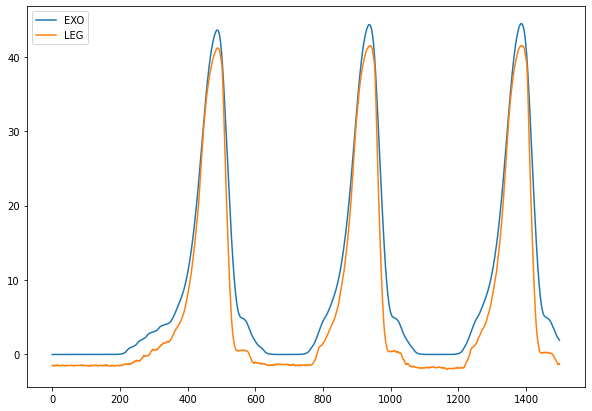



../../../EXOSAFE-DATA/24022021/016-24022021.xlsx
Experimental time shift: 0.5450000000000008
Ideal time shift: 0.6100


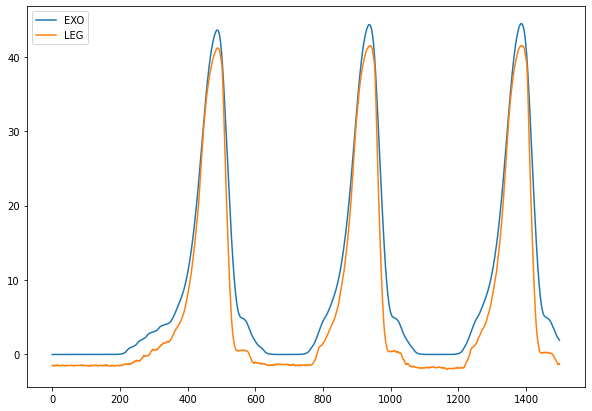



../../../EXOSAFE-DATA/24022021/02-24022021.xlsx
Experimental time shift: 0.4950000000000001
Ideal time shift: 0.4800


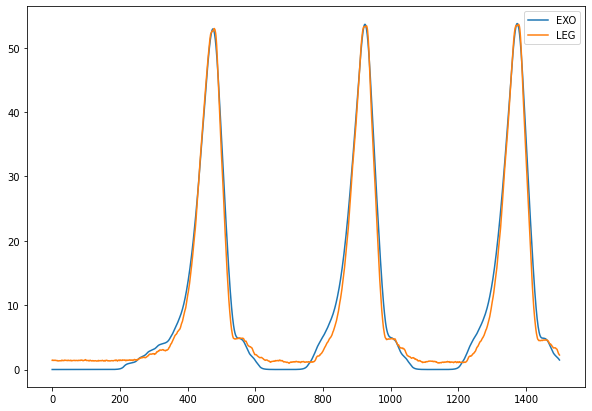



../../../EXOSAFE-DATA/24022021/03-24022021.xlsx
Experimental time shift: 0.9649999999999999
Ideal time shift: 0.9400


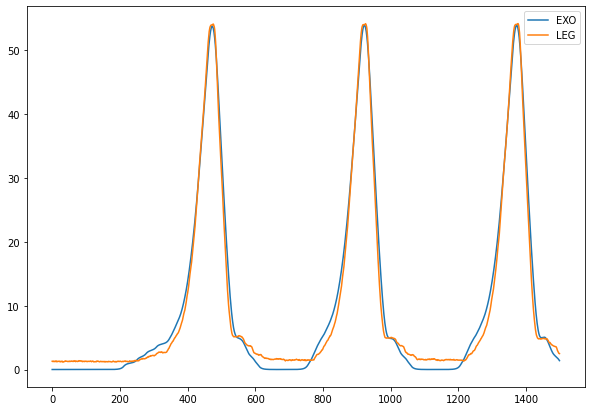



../../../EXOSAFE-DATA/24022021/04-24022021.xlsx
Experimental time shift: 0.020000000000000462
Ideal time shift: 0.0200


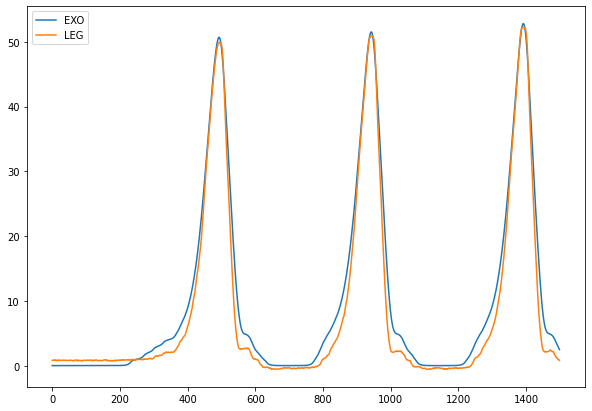



../../../EXOSAFE-DATA/24022021/05-24022021.xlsx
Experimental time shift: 1.1399999999999997
Ideal time shift: 1.1600


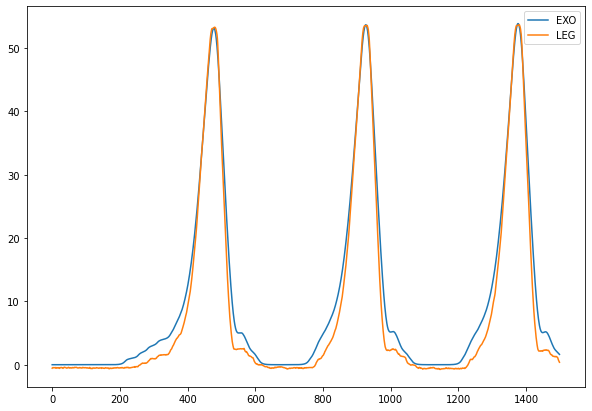



../../../EXOSAFE-DATA/24022021/06-24022021.xlsx
Experimental time shift: 0.21499999999999986
Ideal time shift: 0.2500


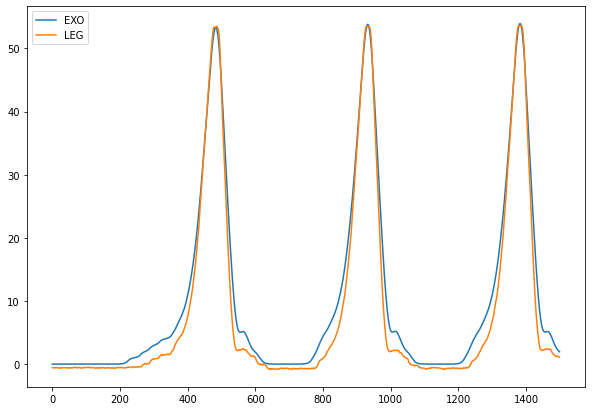



../../../EXOSAFE-DATA/24022021/07-24022021.xlsx
Experimental time shift: 0.6999999999999997
Ideal time shift: 0.7500


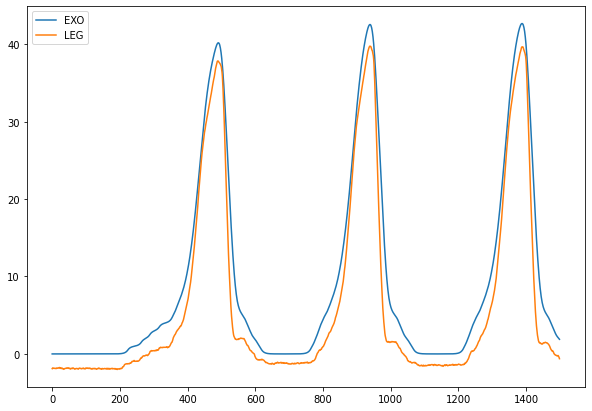



../../../EXOSAFE-DATA/24022021/08-24022021.xlsx
Experimental time shift: 0.6350000000000007
Ideal time shift: 0.7100


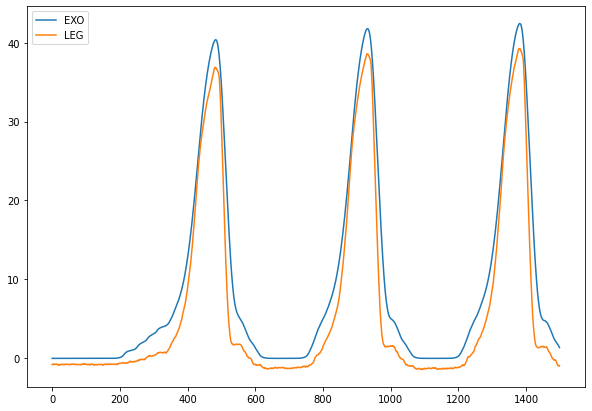



../../../EXOSAFE-DATA/24022021/09-24022021.xlsx
Experimental time shift: 1.1
Ideal time shift: 1.1700


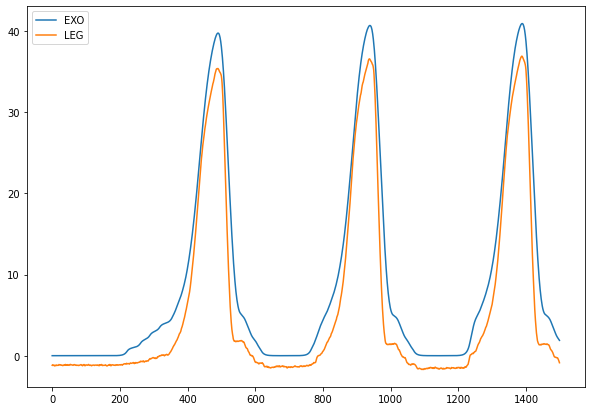



MAE: 0.04674603174603168
MSE: 0.01593531746031743
R2: 0.9111405097663599


In [8]:
exp_ts_ls = []
ts_ls = []

# Check the algorithm for all files
for file in data_ls:
    print(file)
    data_df = pd.read_excel(file, sheet_name=['Parameters', 'H3processed', 'Leg-Replica'])
    
    exp_time_shift = data_df['Parameters'].iloc[0]['TimeShift']
    exp_ts_ls.append(exp_time_shift)
    print('Experimental time shift: {}'.format(exp_time_shift))
    
    exo_arr = data_df['H3processed'].iloc[:, 1].values
    leg_arr = data_df['Leg-Replica'].iloc[:, 3].values
    
    time_shift = compute_time_shift(exo_arr, leg_arr)
    ts_ls.append(time_shift)
    print('Ideal time shift: {:.4f}'.format(time_shift))
    
    leg_df_processed = shift_leg_data(data_df['Leg-Replica'], time_shift, len(data_df['H3processed']))
    
    plt.figure(figsize=(10,7))
    plt.plot(exo_arr[:1500], label='EXO')
    plt.plot(leg_df_processed['LegKneePositionFiltered'].iloc[:1500], label='LEG')
    plt.legend()
    plt.show()

    print('\n')
    
print('MAE: {}'.format(mean_absolute_error(exp_ts_ls, ts_ls)))
print('MSE: {}'.format(mean_squared_error(exp_ts_ls, ts_ls)))
print('R2: {}'.format(r2_score(exp_ts_ls, ts_ls)))